---
# Map of model domain and locations
---

In [1]:
import os
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
#import rioxarray
from array import *
from cmocean import cm as cmo
from glob import glob
from cartopy import crs,feature
import matplotlib as mpl
from matplotlib import pyplot as plt, patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText
#from salishsea_tools import geo_tools, tidetools

In [2]:
if os.sys.platform=="darwin":
    grid_dir = Path('/Volumes/Elements/MIDOSS_Data')
    topo_dir = Path('/Volumes/Elements/MIDOSS_Data')
    graphics_dir = Path('/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics')
else:
    grid_dir = Path('/data/bmoorema/MEOPAR/grid/')
    topo_dir = Path('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/')
    graphics_dir = Path('/ocean/rmueller/MIDOSS/graphics/')
    #geotiff_directory = Path('/data/MIDOSS/geotiffs')

In [3]:
# larger, presentation-size graphics require different xy text specifications
graphics_size='large'
if graphics_size=='large':
    # graphics style
    plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
    
# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3
# reducd dpi to make smaller graphics
custom_dpi=600

In [4]:
mask = xarray.open_dataset(grid_dir/'mesh_mask201702.nc')
coords = xarray.open_dataset(grid_dir/'coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xarray.open_dataset(grid_dir/'bathymetry_201702.nc')
topo = xarray.open_dataset(topo_dir/'ETOPO1_Bed_g_gmt4.grd')
#spills = pandas.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
#lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]
tmask = mask.tmask[0, 0, ...].values

In [56]:
# Annotations
if graphics_size=='large':
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.43, 0.80), 'f':12, 'r':-60,     'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.20), 'f':15, 'r':0,      'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.81, 0.20), 'f':15, 'r':0,       'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Orcas\nIs'           , 'xy': (0.68, 0.395), 'f':9, 'r': 0,     'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.45, 0.30), 'f':12, 'r': -20,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Haro Strait'         , 'xy': (0.62, 0.34), 'f':11, 'r': -70,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.13, 0.72),'f':12,  'r': -20,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'f':15, 'r': 0,  'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Boundary Pass'       , 'xy': (0.82, 0.44), 'f':12, 'r': 0,    'fs':'normal', 'wt': 'bold', 'arrow': (0.73, 0.44,  -0.03,  0.0), 'ha':'center','alpha':None},
        {'name': 'Turn Point'          , 'xy': (0.49, 0.44), 'f':12, 'r': 0,    'fs':'normal', 'wt': 'bold', 'arrow': (0.56, 0.445,  0.02,  -0.01),'ha':'center','alpha':None},     
        #{'name': 'Boundary Pass'       , 'xy': (0.800, 0.42), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.75, 0.44,  -0.03,  0.0), 'ha':'center','alpha':None},
        #{'name': 'Boundary Pass'       , 'xy': (0.800, 0.38), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.8, 0.4,  -0.03,  0.0), 'ha':'center','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.735, 0.585), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]
    annotations_fine = [
        {'name': '1', 'xy': (0.622,0.25), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '2', 'xy': (0.29,0.39), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '3', 'xy': (0.477,0.43), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '4', 'xy': (0.345,0.57), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '5', 'xy': (0.75,0.445), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
    ]
else:
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.41, 0.78), 'r':   -60, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.200), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.810, 0.180), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.475, 0.26), 'r': -17, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.11, 0.717), 'r': -20, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.75, 0.6), 'r':   0, 'wt': 'bold', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]

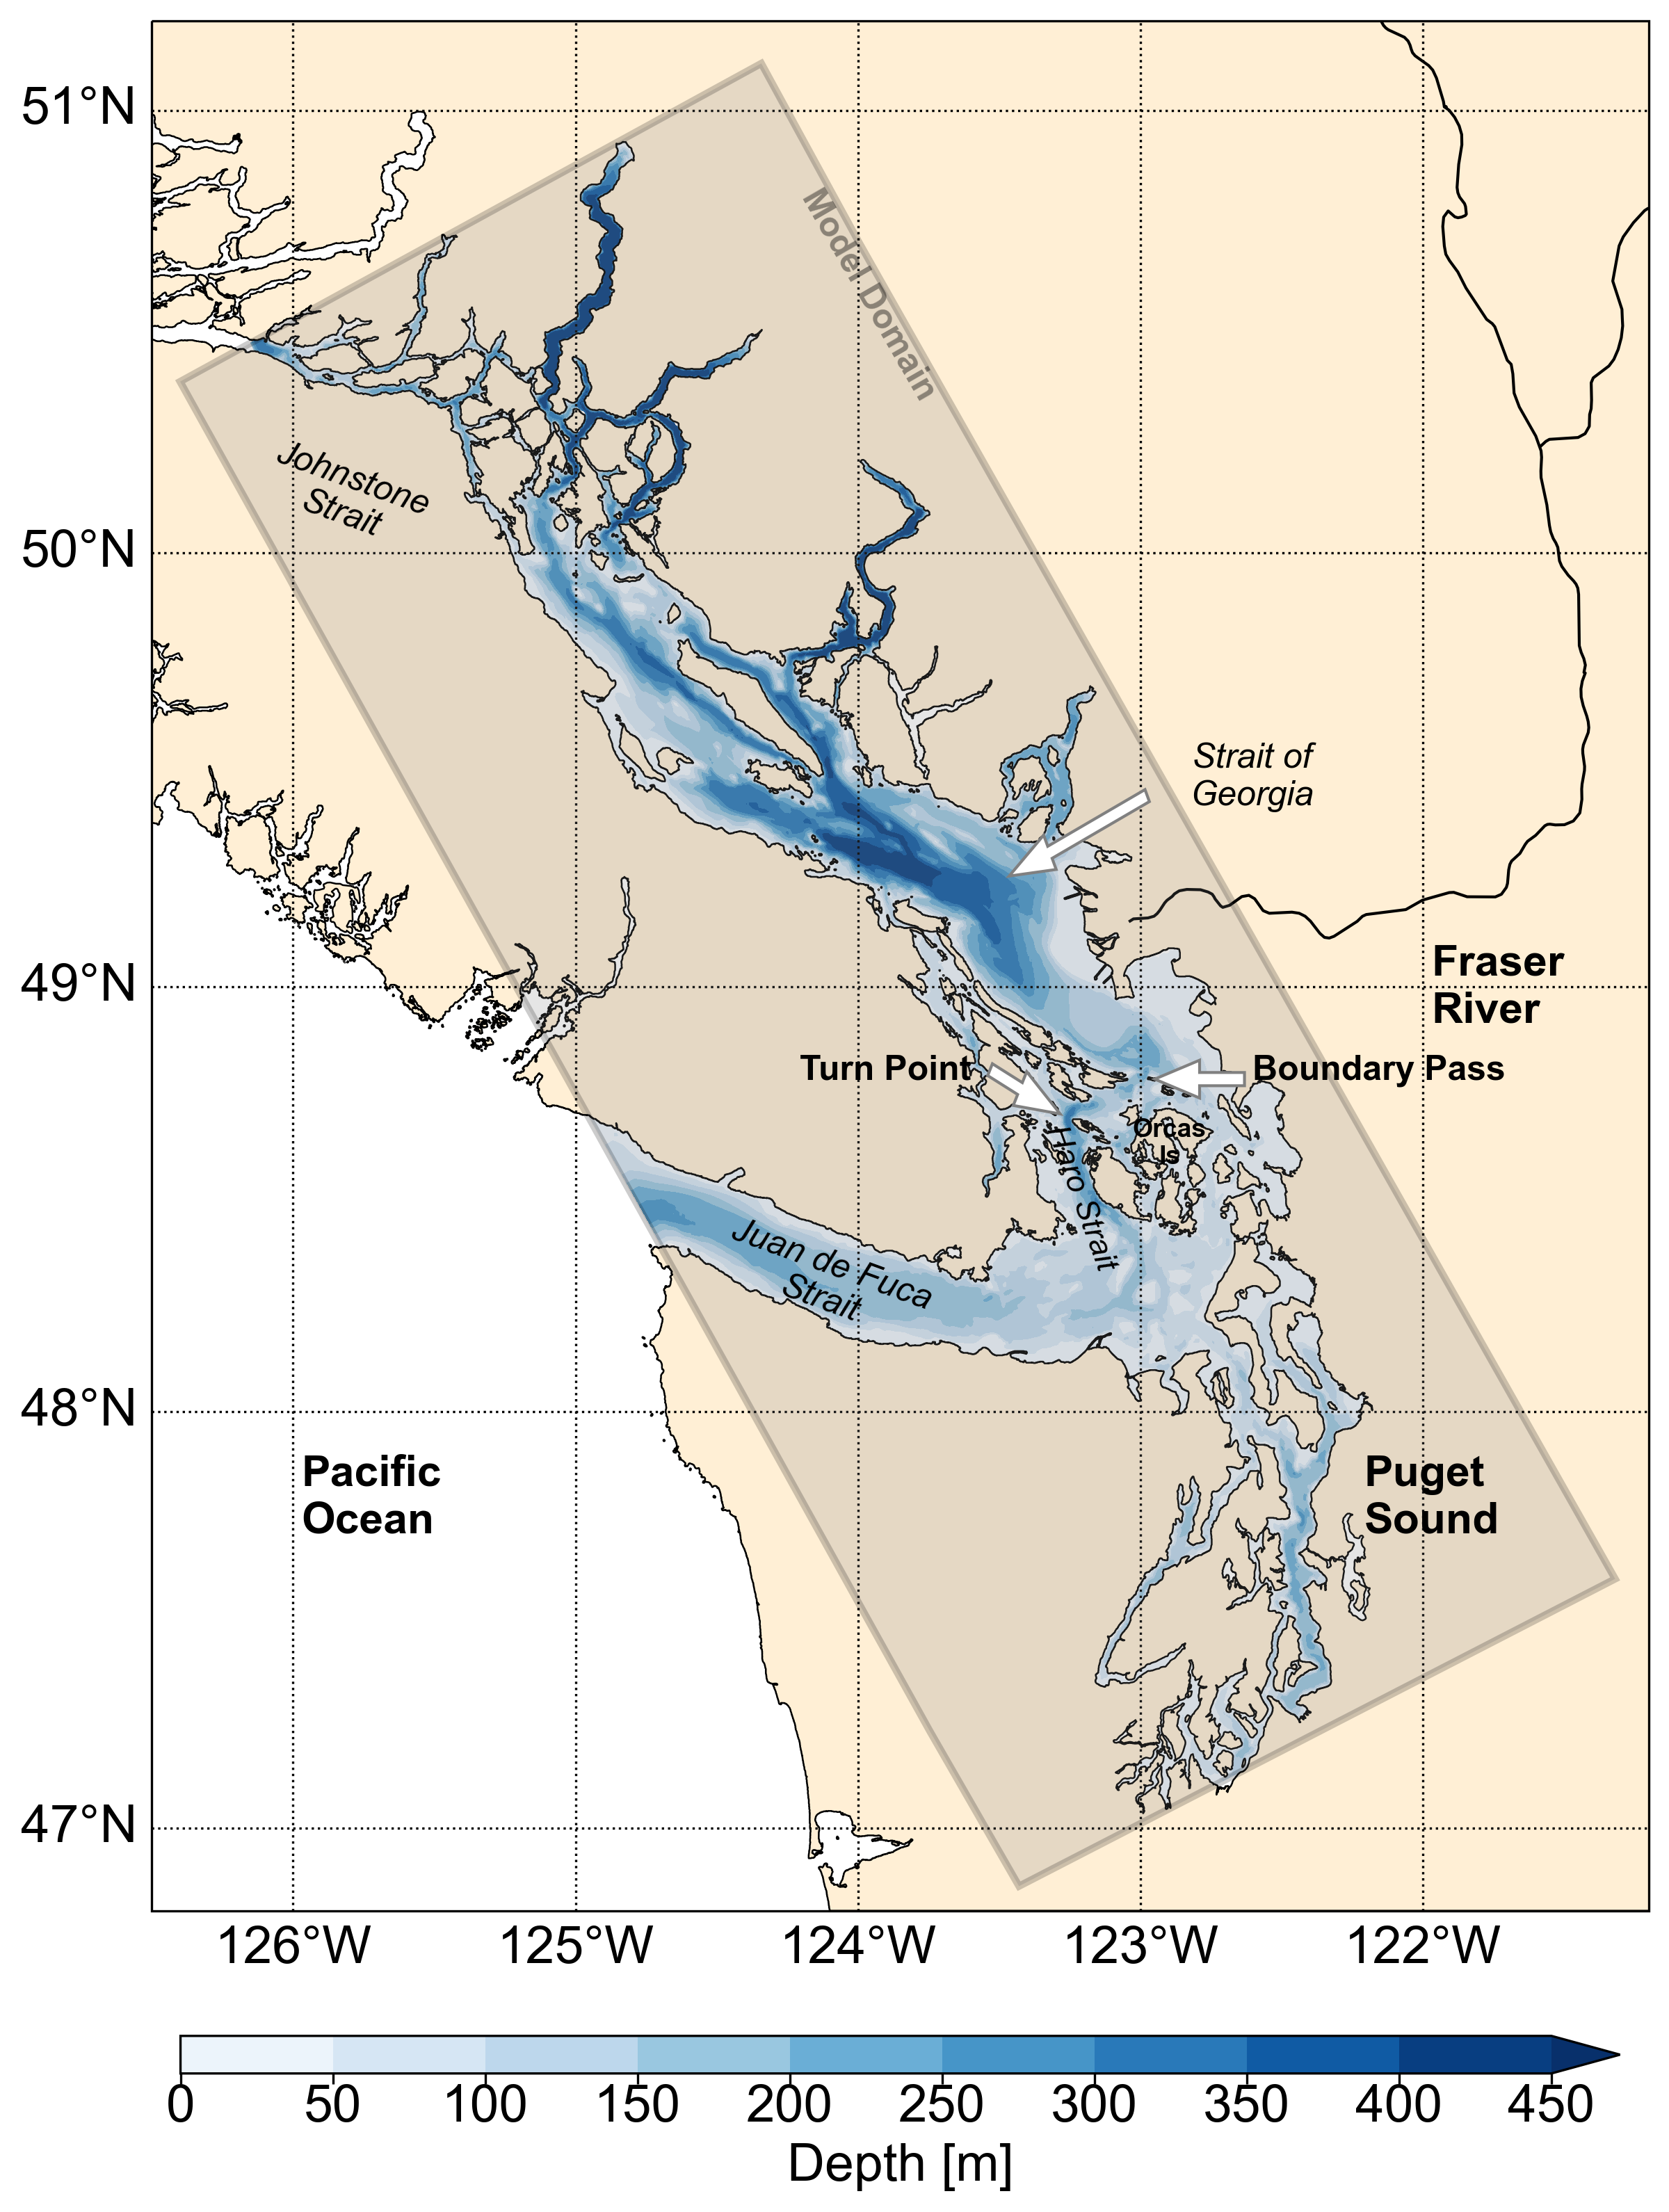

In [57]:
# The code for this figure is a modified version of code from Ben Moore-Maley
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(30, 12))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
#ax.add_patch(patches.Rectangle((-125.3, 49.1), 1.5, 1.2, fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))

# Annotations
for ann in annotations_coarse:
    if ann['alpha'] is not None:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'],
                fontsize=ann['f'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha'],
                alpha=ann['alpha']
               )
    else:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontsize=ann['f'],
                style=ann['fs'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha']
               )
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.007, head_width=0.02, edgecolor='grey', facecolor='white', transform=ax.transAxes, zorder=10)

# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

# save figure
if custom_dpi>=600:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain.png')
else:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain_small.png')
 